In [60]:
import numpy as np
import random
import cv2


def degrade_image(
    image,
    scale=2,
    output_shape=(448, 800),
):
    """
    接受一张高分辨率(HR)图像，应用随机的退化操作生成对应的低分辨率(LR)图像。
    支持多种降采样比例、盲退化方式和数据增强，输入和输出格式可灵活选择。
    参数:
        image: 输入的HR图像。可以是PIL.Image对象、NumPy数组或torch.Tensor。
        scale: 降采样比例，例如2、4、8等。
        output_shape: 输出图像大小，格式为(H, W)。默认为(448, 800)。
    返回:
        (hr_image, lr_image): 元组，其中第一个是处理后的HR图像，第二个是生成的LR图像。
    """
    if isinstance(image, np.ndarray):
        img_np = image.copy()
        if img_np.ndim == 2:
            # 灰度图扩展为三通道
            img_np = np.stack([img_np] * 3, axis=2)
        elif img_np.ndim == 3:
            img_np = img_np[:, :, ::-1]
    else:
        img_np = np.array(image.convert("RGB"), dtype=np.uint8)
    # 获取图像尺寸
    H, W, C = img_np.shape
    # 2. 数据增强：随机翻转
    if random.random() < 0.5:
        img_np = np.flip(img_np, axis=1)  # 水平翻转
    if random.random() < 0.5:
        img_np = np.flip(img_np, axis=0)  # 垂直翻转
    # 随机旋转90度的倍数
    rot_k = random.choice([0, 1, 2, 3])  # 0不旋转，1=90°, 2=180°, 3=270°
    if rot_k != 0:
        img_np = np.rot90(img_np, k=rot_k)
    # 更新尺寸
    H, W = img_np.shape[0], img_np.shape[1]
    # 随机裁剪并填充（保持尺寸不变）
    if random.random() < 0.5:
        random_h = random.random() * 0.3
        random_w = random.random() * 0.3
        max_crop_h = max(1, int(random_h * H))
        max_crop_w = max(1, int(random_w * W))
        dx = random.randint(-max_crop_w, max_crop_w)  # 水平位移（正值表示向右移动）
        dy = random.randint(-max_crop_h, max_crop_h)  # 垂直位移（正值表示向下移动）
        # 计算裁剪区域
        left_crop = max(-dx, 0)  # 若dx为负，裁剪左侧 |dx| 列
        right_crop = max(dx, 0)  # 若dx为正，裁剪右侧 dx 列
        top_crop = max(-dy, 0)  # dy为负，裁剪上方 |dy| 行
        bottom_crop = max(dy, 0)  # dy为正，裁剪下方 dy 行
        rem_h = H - top_crop - bottom_crop  # 剩余高度
        rem_w = W - left_crop - right_crop  # 剩余宽度
        if rem_h > 0 and rem_w > 0:
            # 创建新图像并将裁剪后的原图放置到新图像中
            new_img = np.zeros((H, W, C), dtype=img_np.dtype)
            new_img[top_crop : top_crop + rem_h, left_crop : left_crop + rem_w] = (
                img_np[top_crop : top_crop + rem_h, left_crop : left_crop + rem_w]
            )
            img_np = new_img
            # 图像尺寸H, W保持不变
    # 如果图像尺寸小于目标输出尺寸，则进行填充
    if H < output_shape[0] or W < output_shape[1]:
        pad_h = max(0, output_shape[0] - H)
        pad_w = max(0, output_shape[1] - W)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        img_np = np.pad(
            img_np,
            ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
            mode="reflect",
        )
    # 裁剪到指定输出尺寸
    H, W = img_np.shape[0], img_np.shape[1]
    if H > output_shape[0] or W > output_shape[1]:
        start_h = (H - output_shape[0]) // 2
        start_w = (W - output_shape[1]) // 2
        img_np = img_np[
            start_h : start_h + output_shape[0], start_w : start_w + output_shape[1]
        ]
    # 更新尺寸
    H, W = img_np.shape[0], img_np.shape[1]
    # 增强后的HR图像作为输出高分辨率图像（不含模糊/噪声等退化）
    hr_img = img_np
    # 复制一份用于生成退化的LR图像
    lr_img = hr_img.copy()
    # 3. 盲退化策略：模糊（高斯模糊或运动模糊）
    blur_choice = random.random()
    if blur_choice < 0.33:
        # 高斯模糊
        sigma = random.uniform(0.5, 3.0)  # 随机选择模糊程度
        lr_img = cv2.GaussianBlur(lr_img, (0, 0), sigmaX=sigma, sigmaY=sigma)
    elif blur_choice < 0.66:
        # 运动模糊
        angle = random.choice([0, 45, 90, 135])  # 随机方向
        k = random.choice([3, 5, 7, 9, 11, 13, 15])  # 随机核长度（取奇数）
        if angle == 0:
            # 水平运动模糊
            kernel = np.zeros((1, k), np.float32)
            kernel[0, :] = 1.0 / k
        elif angle == 90:
            # 垂直运动模糊
            kernel = np.zeros((k, 1), np.float32)
            kernel[:, 0] = 1.0 / k
        elif angle == 45:
            # 45° 对角线运动模糊
            kernel = np.zeros((k, k), np.float32)
            np.fill_diagonal(kernel, 1)  # 主对角线为1
            kernel /= k
        else:
            # 135° 对角线运动模糊
            kernel = np.zeros((k, k), np.float32)
            for i in range(k):
                kernel[i, k - 1 - i] = 1.0  # 副对角线为1
            kernel /= k
        # 应用卷积模糊（需将图像转换为BGR，因为OpenCV默认使用BGR通道）
        lr_img_bgr = cv2.cvtColor(lr_img, cv2.COLOR_RGB2BGR)
        lr_img_bgr = cv2.filter2D(lr_img_bgr, -1, kernel)
        lr_img = cv2.cvtColor(lr_img_bgr, cv2.COLOR_BGR2RGB)
    # 如果 blur_choice >= 0.66，则不进行模糊
    # 盲退化策略：噪声（高斯噪声或泊松噪声）
    noise_choice = random.random()
    if noise_choice < 0.33:
        # 添加高斯噪声
        lr_float = lr_img.astype(np.float32)
        sigma_n = random.uniform(1, 10)  # 噪声标准差（像素值范围0-255）
        noise = np.random.normal(0, sigma_n, lr_float.shape)
        lr_float += noise
        lr_img = np.clip(lr_float, 0, 255).astype(np.uint8)
    elif noise_choice < 0.66:
        # 添加泊松噪声
        lr_float = lr_img.astype(np.float32)
        vals = np.random.poisson(lr_float)  # 以每个像素值为λ参数采样泊松噪声
        lr_img = np.clip(vals, 0, 255).astype(np.uint8)
    # 若 noise_choice >= 0.66，则不加噪声
    # 盲退化策略：颜色偏移与伪影
    # 对RGB三个通道应用随机缩放，模拟颜色失真
    lr_float = lr_img.astype(np.float32)
    factors = [random.uniform(0.9, 1.1) for _ in range(3)]
    for c in range(3):
        lr_float[:, :, c] *= factors[c]
    lr_img = np.clip(lr_float, 0, 255).astype(np.uint8)
    # 盲退化策略：随机下采样（降分辨率）
    new_h = max(1, int(H // scale))
    new_w = max(1, int(W // scale))
    interp = random.choice([cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC])
    # 注意：cv2.resize 的参数顺序为 (width, height)
    lr_img = cv2.resize(lr_img, (new_w, new_h), interpolation=interp)
    # 盲退化策略：JPEG压缩造成的伪影
    if random.random() < 0.5:
        quality = random.randint(30, 95)  # 随机JPEG质量（数值越低失真越明显）
        _, enc = cv2.imencode(
            ".jpg",
            cv2.cvtColor(lr_img, cv2.COLOR_RGB2BGR),
            [int(cv2.IMWRITE_JPEG_QUALITY), quality],
        )
        lr_img = cv2.imdecode(enc, cv2.IMREAD_COLOR)
        lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)  # 转回RGB通道
    # 4. 按要求的格式返回结果
    out_hr, out_lr = hr_img, lr_img
    out_hr = hr_img.astype(np.uint8)
    out_lr = lr_img.astype(np.uint8)
    return out_hr, out_lr

(448, 800, 3) (56, 100, 3)


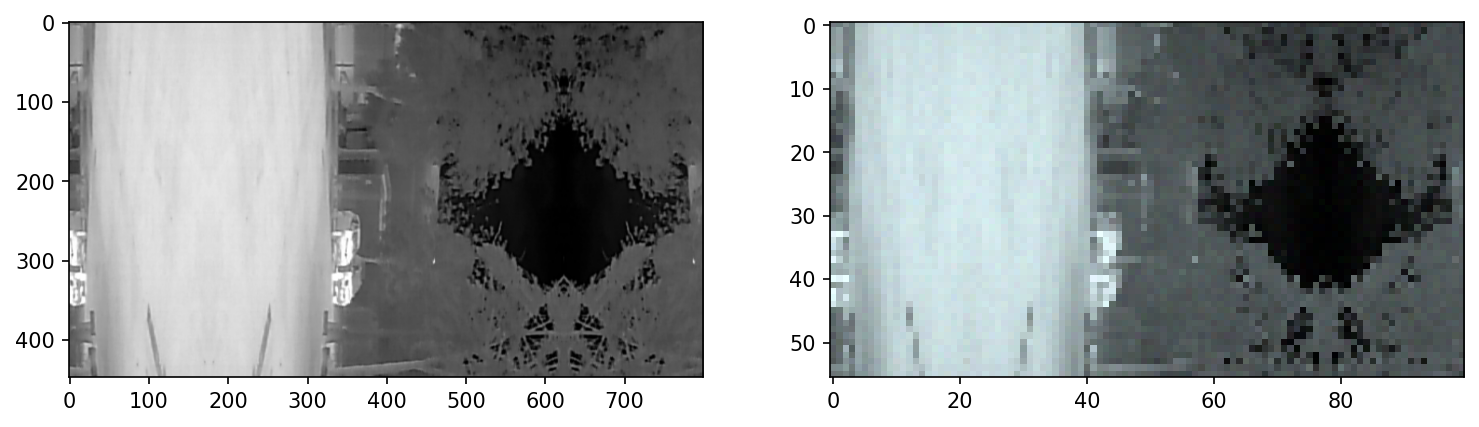

In [62]:
img = cv2.imread(
    "/media/hdd/sonwe1e/Competition/PBVS_Thermal/Data/train/GT/001_02_D1_th.bmp"
)
hr, lr = degrade_image(img, scale=8)
print(hr.shape, lr.shape)
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 150

plt.subplot(121)
plt.imshow(hr)
plt.subplot(122)
plt.imshow(lr)
plt.show()
